In [14]:
#perform neighbor enrichment analysis with squidpy
import anndata
import cellcharter as cc
import pandas as pd
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import time, os, sys
import glob
import warnings
import numpy as np
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)



In [15]:
#import simualted data
path_to_csv = './../../../MI_heart_paper/data/cell_table_final.csv'
obs = pd.read_csv(path_to_csv)

In [16]:
#filter out cell types
ignore_cell_types = ['exclude']
obs = obs[~obs['final_cell_type'].isin(ignore_cell_types)]

# add marker files to it, as SpatialLDA needs them
obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Ensure obs has a string-based index
obs.index = obs.index.astype(str)  # Convert index to string


# Load dataframe into anndata object
# the data matrix 
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs
adata

AnnData object with n_obs × n_vars = 563180 × 2
    obs: 'fov', 'label', 'cell_size', 'X_centroid', 'Y_centroid', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'cell_meta_cluster', 'timepoint', 'region', 'region_name', 'refined_cell_type', 'final_cell_type', 'endocardial_annotation', 'exclude_annotation', 'artefact', 'distance_from_lumen', 'lumen_bin', 'size_filter', 'D', 'E'

In [17]:
adata.obs['final_cell_type'].value_counts()

final_cell_type
Cardiomyocytes            323252
Endothelial cells          87804
Cardiomyocytes Ankrd1+     64779
Fibroblasts                38328
Mono / Macros Ccr2+        18966
Neutrophils                 9519
Smooth muscle cells         8396
Endocardial cells           5187
Macrophages Trem2+          4206
Other Leukocytes            1776
Macrophages Trem2-           967
Name: count, dtype: int64

In [7]:
adata.obs

,fov,label,cell_size,X_centroid,Y_centroid,Eccentricity,Solidity,Extent,Orientation,cell_meta_cluster,...,refined_cell_type,final_cell_type,endocardial_annotation,exclude_annotation,artefact,distance_from_lumen,lumen_bin,size_filter,D,E
7,24h_86,8,1433,13794.937195,4311.645499,0.688445,0.967589,0.765491,-1.181936,Fibroblasts,...,Fibroblasts,Fibroblasts,0,False,False,5864.498274,74.0,False,13,55
8,24h_86,9,1516,14441.179420,4319.424142,0.784424,0.971795,0.697653,-1.035882,Mono / Macros Ccr2+,...,Mono / Macros Ccr2+,Mono / Macros Ccr2+,0,False,False,5585.793140,70.0,False,72,42
10,24h_86,11,6035,14374.174979,4344.383099,0.568614,0.960987,0.779414,-0.738112,Cardiomyocytes,...,Cardiomyocytes,Cardiomyocytes,0,False,False,5590.969952,70.0,False,46,77
11,24h_86,12,5298,14523.473575,4335.610608,0.694712,0.955283,0.672506,-1.338075,Cardiomyocytes,...,Cardiomyocytes,Cardiomyocytes,0,False,False,5537.948447,70.0,False,72,33
13,24h_86,14,1163,14597.668100,4324.958727,0.689784,0.946298,0.615344,0.869137,Mono / Macros Ccr2+,...,Mono / Macros Ccr2+,Mono / Macros Ccr2+,0,False,False,5518.948088,69.0,False,54,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628357,Control_14,82106,1080,13974.990741,24152.720370,0.776084,0.952381,0.725806,-1.352395,Fibroblasts,...,Fibroblasts,Fibroblasts,0,False,False,9135.596806,115.0,False,33,51
628358,Control_14,82107,3235,12336.925502,24169.496754,0.644124,0.906925,0.660609,1.134052,Fibroblasts,...,Fibroblasts,Fibroblasts,0,False,False,8896.518982,112.0,False,77,75
628359,Control_14,82108,10610,12189.037606,24193.085862,0.866968,0.951911,0.664787,-1.300009,Cardiomyocytes,...,Cardiomyocytes,Cardiomyocytes,0,False,False,8911.967516,112.0,False,32,6
628360,Control_14,82109,2077,12287.895041,24183.298507,0.510616,0.971014,0.714482,-1.363983,Cardiomyocytes,...,Cardiomyocytes,Cardiomyocytes,0,False,False,8907.383510,112.0,False,75,42


In [18]:
# get spatial coordinates to be in obsm
adata.obsm['spatial'] = obs[['X_centroid', 'Y_centroid']].values


In [19]:
# make "refined_cell_types" a categorical variable
adata.obs['final_cell_type'] = pd.Categorical(adata.obs['final_cell_type'])

In [20]:

# Assuming 'FOV' is the column in obs indicating different fields of view
fov_list = adata.obs['fov'].unique()

# Dictionary to store FOV-specific AnnData objects
fov_adata_dict = {}

# Loop over each FOV
for fov in fov_list:
    # Create a subset of adata for the specific FOV
    fov_adata = adata[adata.obs['fov'] == fov].copy()

    # Perform spatial neighbors analysis on the subset
    sq.gr.spatial_neighbors(fov_adata, coord_type = 'generic', delaunay=True)
    cc.gr.nhood_enrichment(fov_adata, cluster_key="final_cell_type", n_perms=300, only_inter=True)
    # Store the result in the dictionary
    fov_adata_dict[fov] = fov_adata


In [21]:
import pandas as pd

# Initialize a list to hold each flattened DataFrame
flattened_dfs = []

# Loop through each fov in the dictionary
for fov, fov_adata in fov_adata_dict.items():
    # Extract the zscore matrix
    zscore_matrix = fov_adata.uns['final_cell_type_nhood_enrichment']['enrichment']

    # Get the refined cell types from adata.obs (ensure it's categorical)
    cell_types = fov_adata.obs['final_cell_type'].cat.categories

    # Check if the dimensions of the zscore matrix match the number of categories
    assert len(cell_types) == zscore_matrix.shape[0] == zscore_matrix.shape[1], "Dimension mismatch!"

    # Convert the zscore matrix to a pandas DataFrame with correct row and column names
    zscore_df = pd.DataFrame(zscore_matrix, index=cell_types, columns=cell_types)

    # Flatten the DataFrame
    flattened_df = zscore_df.stack().reset_index()

    # Rename the columns to combine row and column names
    flattened_df.columns = ['rowname', 'colname', 'zscore']

    # Create a new column for combined names
    flattened_df['combined'] = flattened_df['rowname'] + '_' + flattened_df['colname']

    # Add a column for the FOV name
    flattened_df['fov'] = fov

    # Retain only the combined, zscore, and fov columns
    flattened_df = flattened_df[['fov', 'combined', 'zscore']]

    # Append the flattened DataFrame to the list
    flattened_dfs.append(flattened_df)

# Concatenate all flattened DataFrames into one big DataFrame
big_dataframe = pd.concat(flattened_dfs, ignore_index=True)

# Pivot the DataFrame to have FOVs as row names and combined names as column names
final_dataframe = big_dataframe.pivot(index='fov', columns='combined', values='zscore')

# Reset the index to make FOV a column (optional)
final_dataframe.reset_index('fov',inplace=True)

# Display the final DataFrame
print(final_dataframe)


combined         fov  Cardiomyocytes Ankrd1+_Cardiomyocytes  \
0             24h_83                              -0.182220   
1             24h_86                              -0.078249   
2             48h_76                              -0.244708   
3             48h_79                              -0.249201   
4              4h_96                               0.156597   
5              4h_97                              -0.013308   
6         Control_12                              -0.065895   
7         Control_13                              -0.114278   
8         Control_14                              -0.205361   

combined  Cardiomyocytes Ankrd1+_Endocardial cells  \
0                                        -0.009912   
1                                        -0.009149   
2                                        -0.013963   
3                                        -0.008642   
4                                        -0.007320   
5                                        -0.0

In [22]:
# make fov to index
final_dataframe.set_index('fov', inplace=True)
# save the files
final_dataframe.to_csv('./../../github/Comparison/20250218_results_MI/cellcharter_nohomo_nhood_enrichment_MI_data.csv', index=True)

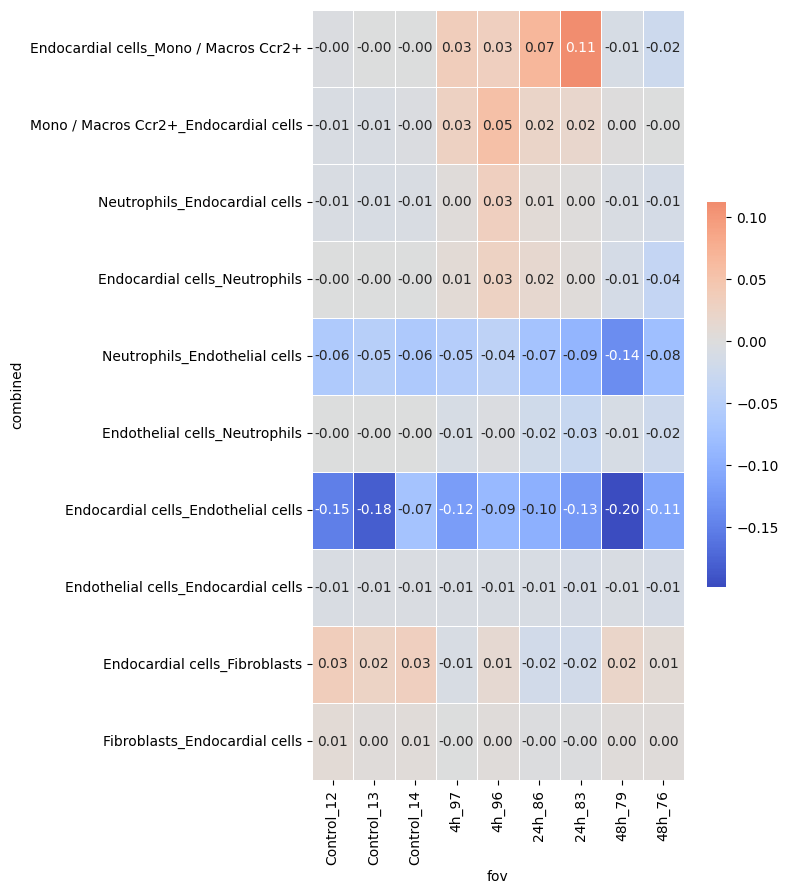

In [11]:
column_order = [
    'Control_12', 'Control_13', 'Control_14', '4h_97', '4h_96', '24h_86',
    '24h_83', '48h_79', '48h_76'
]

desired_rows = [
    'Endocardial cells_Mono / Macros Ccr2+',
    'Mono / Macros Ccr2+_Endocardial cells', 
    'Neutrophils_Endocardial cells', 
    'Endocardial cells_Neutrophils',
    'Neutrophils_Endothelial cells', 
    'Endothelial cells_Neutrophils',
    'Endocardial cells_Endothelial cells', 
    'Endothelial cells_Endocardial cells',
    'Endocardial cells_Fibroblasts', 
    'Fibroblasts_Endocardial cells',
]  # Replace with your row names

# Ensure the DataFrame is transposed
transposed_df = final_dataframe.set_index('fov').T

# Ensure the provided order matches existing columns and reorder them
transposed_df = transposed_df[column_order]
# Filter the DataFrame for these row names
transposed_df = transposed_df.loc[desired_rows]

# Create a plot
f, ax = plt.subplots(figsize=(6, 10))

# Draw the heatmap
sns.heatmap(transposed_df,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".2f",
            linewidths=.5,#annot=True,
            cbar_kws={"shrink": .5})

plt.show()

# COUNTS

In [43]:
#now check the extracted count

# Initialize a list to hold each flattened DataFrame
flattened_dfs = []

# Loop through each fov in the dictionary
for fov, fov_adata in fov_adata_dict.items():
    # Extract the zscore matrix
    zscore_matrix = fov_adata.uns['final_cell_type_nhood_enrichment']['count']

    # Get the refined cell types from adata.obs (ensure it's categorical)
    cell_types = fov_adata.obs['final_cell_type'].cat.categories

    # Check if the dimensions of the zscore matrix match the number of categories
    assert len(cell_types) == zscore_matrix.shape[0] == zscore_matrix.shape[1], "Dimension mismatch!"

    # Convert the zscore matrix to a pandas DataFrame with correct row and column names
    zscore_df = pd.DataFrame(zscore_matrix, index=cell_types, columns=cell_types)

    # Flatten the DataFrame
    flattened_df = zscore_df.stack().reset_index()

    # Rename the columns to combine row and column names
    flattened_df.columns = ['rowname', 'colname', 'count']

    # Create a new column for combined names
    flattened_df['combined'] = flattened_df['rowname'] + '_' + flattened_df['colname']

    # Add a column for the FOV name
    flattened_df['fov'] = fov

    # Retain only the combined, zscore, and fov columns
    flattened_df = flattened_df[['fov', 'combined', 'count']]

    # Append the flattened DataFrame to the list
    flattened_dfs.append(flattened_df)

# Concatenate all flattened DataFrames into one big DataFrame
big_dataframe = pd.concat(flattened_dfs, ignore_index=True)

# Pivot the DataFrame to have FOVs as row names and combined names as column names
final_dataframe = big_dataframe.pivot(index='fov', columns='combined', values='count')

# Reset the index to make FOV a column (optional)
final_dataframe.reset_index('fov',inplace=True)

# Display the final DataFrame
print(final_dataframe)



combined         fov  Cardiomyocytes Ankrd1+_Cardiomyocytes  \
0             24h_83                                   5088   
1             24h_86                                  11411   
2             48h_76                                   1865   
3             48h_79                                   2202   
4              4h_96                                  21167   
5              4h_97                                  13542   
6         Control_12                                   3237   
7         Control_13                                    200   
8         Control_14                                    173   

combined  Cardiomyocytes Ankrd1+_Cardiomyocytes Ankrd1+  \
0                                                 61474   
1                                                 42620   
2                                                 27150   
3                                                 34770   
4                                                 53512   
5              

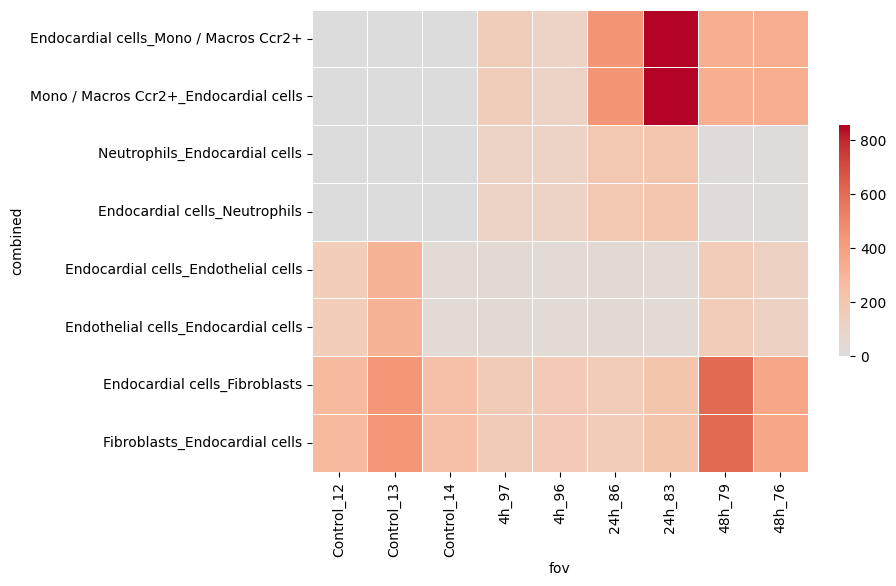

In [44]:
column_order = [
    'Control_12', 'Control_13', 'Control_14', '4h_97', '4h_96', '24h_86',
    '24h_83', '48h_79', '48h_76'
]

desired_rows = [
    'Endocardial cells_Mono / Macros Ccr2+',
    'Mono / Macros Ccr2+_Endocardial cells', 'Neutrophils_Endocardial cells', 'Endocardial cells_Neutrophils',
    'Endocardial cells_Endothelial cells', 'Endothelial cells_Endocardial cells',
    'Endocardial cells_Fibroblasts', 'Fibroblasts_Endocardial cells',
]  # Replace with your row names

# Ensure the DataFrame is transposed
transposed_df = final_dataframe.set_index('fov').T

# Ensure the provided order matches existing columns and reorder them
transposed_df = transposed_df[column_order]
# Filter the DataFrame for these row names
transposed_df = transposed_df.loc[desired_rows]

# Create a plot
f, ax = plt.subplots(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(transposed_df,
            cmap='coolwarm',
            center=0,
            annot=False,
            fmt=".1f",
            linewidths=.5,#annot=True,
            cbar_kws={"shrink": .5})

plt.show()

In [17]:
final_dataframe.to_csv('./../../../SCNA_thesis/github/Comparison/results_4ct_sym/squidpy_zscore_delaunay_4ct_cross01', index=False)  # Set index=False to avoid saving the index as a column
final_dataframe

combined,sample_id,0.0_0.0,0.0_1.0,0.0_2.0,0.0_3.0,1.0_0.0,1.0_1.0,1.0_2.0,1.0_3.0,2.0_0.0,2.0_1.0,2.0_2.0,2.0_3.0,3.0_0.0,3.0_1.0,3.0_2.0,3.0_3.0
0,ran_ab0_0.05_sim_1,-0.468912,0.702968,-1.478445,0.940030,0.702968,0.495653,-0.139258,-0.046530,-1.478445,-0.139258,-0.008342,-0.099416,0.940030,-0.046530,-0.099416,0.036242
1,ran_ab0_0.05_sim_10,0.491067,0.478510,0.644148,-1.001822,0.478510,0.001041,-0.880057,1.961973,0.644148,-0.880057,-0.947547,-0.176654,-1.001822,1.961973,-0.176654,-0.889855
2,ran_ab0_0.05_sim_100,-2.390571,2.103360,0.738203,0.359043,2.103360,-0.631696,0.406858,-0.982304,0.738203,0.406858,-0.744002,-0.637207,0.359043,-0.982304,-0.637207,0.983691
3,ran_ab0_0.05_sim_11,-0.780619,0.072862,2.166228,-1.213803,0.072862,-0.292447,-0.466557,0.723570,2.166228,-0.466557,1.540194,-2.562517,-1.213803,0.723570,-2.562517,1.271717
4,ran_ab0_0.05_sim_12,-0.317667,-0.364624,0.200971,0.293584,-0.364624,-0.657375,2.593176,-0.881514,0.200971,2.593176,-1.188647,-0.024213,0.293584,-0.881514,-0.024213,-0.590549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,self_0.6_ab0_0.2_sim_95,6.821838,-3.156579,-3.272939,-2.075701,-3.156579,0.112366,1.373685,1.475396,-3.272939,1.373685,-0.523326,1.729573,-2.075701,1.475396,1.729573,-1.241248
1496,self_0.6_ab0_0.2_sim_96,9.742375,-3.925717,-4.663755,-4.197810,-3.925717,0.697289,1.911006,1.774381,-4.663755,1.911006,-0.543989,1.987233,-4.197810,1.774381,1.987233,0.241401
1497,self_0.6_ab0_0.2_sim_97,6.858831,-4.276363,-3.710569,-3.196047,-4.276363,2.692956,-0.390860,0.648769,-3.710569,-0.390860,3.593652,-0.565035,-3.196047,0.648769,-0.565035,4.037652
1498,self_0.6_ab0_0.2_sim_98,7.542396,-3.984240,-4.371325,-0.753142,-3.984240,0.562535,1.382632,2.093963,-4.371325,1.382632,0.547934,-0.375378,-0.753142,2.093963,-0.375378,0.251570
